# Load Data and Word-Embedding Models

In [1]:
import os
import re
import json
import gensim   
import gensim.downloader as api
import torch.optim as optim
import numpy as np
import torch
import torch.nn as nn
from sklearn.metrics import accuracy_score, f1_score

# Load data
train_data = json.load(open('NER_train_data_v2.json', 'r'))
val_data = json.load(open('NER_val_data_v2.json', 'r'))
test_data = json.load(open('NER_test_data_v2.json', 'r'))

# Load pre-trained word2vec model
word2vec = api.load("word2vec-google-news-300")
glove = api.load("glove-wiki-gigaword-300")
fasttext = api.load("fasttext-wiki-news-subwords-300")

In [3]:
def get_embedding(word, embedding_model, size):
    try:
        # print('word2vec')
        return torch.tensor(embedding_model[word])
    except:
        # print('ones')
        return torch.ones(size)

# BiLSTM-CRF Implementation

In [67]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchcrf import CRF

class BiLSTM_CRF(nn.Module):
    def __init__(self, input_size, hidden_size, num_tags):
        super(BiLSTM_CRF, self).__init__()
        self.hidden_size = hidden_size
        self.num_tags = num_tags

        # BiLSTM layer
        self.lstm = nn.LSTM(input_size, hidden_size//2, batch_first=True, bidirectional=True)
        # Maps the output of the LSTM into tag space.
        self.hidden2tag = nn.Linear(hidden_size, num_tags)
        # CRF layer
        self.crf = CRF(num_tags)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        lstm_feats = self.hidden2tag(lstm_out)
        return lstm_feats

    def neg_log_likelihood(self, x, tags):
        emissions = self(x)
        return -self.crf(emissions, tags)

    def forward_crf(self, x):
        emissions = self(x)
        out = self.crf.decode(emissions)
        out = torch.tensor(out)
        out = torch.nn.functional.one_hot(out, num_classes=self.num_tags)
        out = out.permute(1, 0, 2)
        return out

# Example usage:
input_size = 300  # Example input size
hidden_size = 50  # Example hidden size
num_tags = 27  # Example number of tags
criteria = nn.CrossEntropyLoss()

# Example forward pass with CRF
model = BiLSTM_CRF(input_size, hidden_size, num_tags)
inputs = torch.randn(1, 19, input_size)  # Example input tensor
tags = torch.tensor([[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]])  # Example tag tensor

neg_log_likelihood = model.neg_log_likelihood(inputs, tags)
decoded_tags = model.forward_crf(inputs)
print(inputs.shape, tags.shape)
print(decoded_tags.shape, '2')
loss = criteria(decoded_tags.float().view(-1, 27), tags.squeeze(0))
print(neg_log_likelihood)

torch.Size([1, 19, 300]) torch.Size([1, 19])
torch.Size([1, 19, 27]) 2
tensor(63.1905, grad_fn=<NegBackward0>)


# Training and Validation Code

In [24]:
def training_and_validation(model, embedding_model, train_data, val_data, criterion, optimizer,
            device='cuda', epochs=10):
    label_mapping = {'O': 0, 'B_CASE_NUMBER': 1, 'I_CASE_NUMBER': 2, 'B_ORG': 3, 'I_ORG': 4, 'B_OTHER_PERSON': 5, 'I_OTHER_PERSON': 6, 'B_STATUTE': 7, 'I_STATUTE': 8, 'B_PROVISION': 9, 'I_PROVISION': 10, 'B_COURT': 11, 'I_COURT': 12, 'B_WITNESS': 13, 'B_PRECEDENT': 14, 'I_PRECEDENT': 15, 'B_DATE': 16, 'B_PETITIONER': 17, 'I_PETITIONER': 18, 'I_WITNESS': 19, 'B_GPE': 20, 'B_RESPONDENT': 21, 'I_RESPONDENT': 22, 'I_DATE': 23, 'B_JUDGE': 24, 'I_JUDGE': 25, 'I_GPE': 26}
    output_size = len(label_mapping)
    
    model = model.to(device)
    training_loss, validation_loss = [], []
    training_f1, validation_f1 = [], []
    
    for epoch in range(epochs):
        print(f'Epoch {epoch + 1}/{epochs}')

        ###################### TRAINING STEP ####################
        model.train()
        train_actual = []
        train_predicted = []
        train_loss = 0
        
        for _, data in train_data.items():
            text = data["text"]
            pattern = r'[ ]+'
            text = re.split(pattern, text)
            labels = data["labels"]
            # Convert text to embeddings
            embedded_text = torch.stack([get_embedding(token, embedding_model, 300) for token in text])
            embedded_text = embedded_text.unsqueeze(0)
            targets = torch.tensor([[label_mapping[label] for label in labels]], dtype=torch.long)
            embedded_text, targets = embedded_text.to(device), targets.to(device)
            # Forward pass
            outputs = model(embedded_text)
            # Compute loss
            targets = targets.squeeze(0)
            loss = criterion(outputs.float().view(-1, output_size), targets)
            # loss = model.neg_log_likelihood(embedded_text, targets)
            train_predicted.extend(outputs.squeeze(0).argmax(dim=1).tolist())
            train_actual.extend(targets.tolist())     
            train_loss += loss.item()       
            # Backward pass and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        train_loss = train_loss / len(train_data)
        accuracy = accuracy_score(train_actual, train_predicted)
        f1 = f1_score(train_actual, train_predicted, average="macro")
        training_loss.append(train_loss)
        training_f1.append(f1)
        print(f"Training: Loss: {train_loss:.4f}, Accuracy: {accuracy:.4f}, F1: {f1:.4f}")
        
        ###################### VALIDATION STEP ####################
        model.eval()
        validation_actual = []
        validation_predicted = []
        val_loss = 0
        with torch.no_grad():
            for _, data in val_data.items():
                text = data["text"]
                pattern = r'[ ]+'
                text = re.split(pattern, text)
                labels = data["labels"]
                # Convert text to embeddings
                embedded_text = torch.stack([get_embedding(token, embedding_model, 300) for token in text])
                embedded_text = embedded_text.unsqueeze(0)
                targets = torch.tensor([[label_mapping[label] for label in labels]], dtype=torch.long)
                embedded_text, targets = embedded_text.to(device), targets.to(device)
                # Forward pass
                outputs = model(embedded_text)
                # Compute loss
                targets = targets.squeeze(0)
                loss = criterion(outputs.float().view(-1, output_size), targets)
                validation_predicted.extend(outputs.squeeze(0).argmax(dim=1).tolist())
                validation_actual.extend(targets.tolist())     
                val_loss += loss.item()
            val_loss = val_loss / len(val_data)
            accuracy = accuracy_score(validation_actual, validation_predicted)
            f1 = f1_score(validation_actual, validation_predicted, average="macro")
            validation_loss.append(val_loss)
            validation_f1.append(f1)
            print(f"Validation: Loss: {val_loss:.4f}, Accuracy: {accuracy:.4f}, F1: {f1:.4f}")
    
    return training_loss, validation_loss, training_f1, validation_f1
        

# Fine-Tuning on Validation Data

In [25]:
def fine_tune(model, embedding_model, val_data,  criterion, optimizer, device='cuda', epochs=3):
    label_mapping = {'O': 0, 'B_CASE_NUMBER': 1, 'I_CASE_NUMBER': 2, 'B_ORG': 3, 'I_ORG': 4, 'B_OTHER_PERSON': 5, 'I_OTHER_PERSON': 6, 'B_STATUTE': 7, 'I_STATUTE': 8, 'B_PROVISION': 9, 'I_PROVISION': 10, 'B_COURT': 11, 'I_COURT': 12, 'B_WITNESS': 13, 'B_PRECEDENT': 14, 'I_PRECEDENT': 15, 'B_DATE': 16, 'B_PETITIONER': 17, 'I_PETITIONER': 18, 'I_WITNESS': 19, 'B_GPE': 20, 'B_RESPONDENT': 21, 'I_RESPONDENT': 22, 'I_DATE': 23, 'B_JUDGE': 24, 'I_JUDGE': 25, 'I_GPE': 26}
    output_size = len(label_mapping)
    model = model.to(device)
    model.train()
    
    for epoch in range(epochs):
        print(f'Epoch {epoch + 1}/{epochs}')
        tuning_loss = 0
        actual = []
        predicted = []
        for _, data in val_data.items():
            text = data["text"]
            pattern = r'[ ]+'
            text = re.split(pattern, text)
            labels = data["labels"]
            # Convert text to embeddings
            embedded_text = torch.stack([get_embedding(token, embedding_model, 300) for token in text])
            embedded_text = embedded_text.unsqueeze(0)
            targets = torch.tensor([[label_mapping[label] for label in labels]], dtype=torch.long)
            embedded_text, targets = embedded_text.to(device), targets.to(device)
            # Forward pass
            outputs = model(embedded_text)
            # Compute loss
            targets = targets.squeeze(0)
            loss = criterion(outputs.float().view(-1, output_size), targets)
            predicted.extend(outputs.squeeze(0).argmax(dim=1).tolist())
            actual.extend(targets.tolist())     
            tuning_loss += loss.item()       
            # Backward pass and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        tuning_loss = tuning_loss / len(val_data)
        accuracy = accuracy_score(actual, predicted)
        f1 = f1_score(actual, predicted, average="macro")
        print(f"FineTuning: Loss: {tuning_loss:.4f}, Accuracy: {accuracy:.4f}, F1: {f1:.4f}")
        

# Testing Code

In [26]:
def test(model, embedding_model, test_data, device='cuda', show_labelwise=False, plot=False):
    if type(model) == str:
        model = torch.load(model)
    label_mapping = {'O': 0, 'B_CASE_NUMBER': 1, 'I_CASE_NUMBER': 2, 'B_ORG': 3, 'I_ORG': 4, 'B_OTHER_PERSON': 5, 'I_OTHER_PERSON': 6, 'B_STATUTE': 7, 'I_STATUTE': 8, 'B_PROVISION': 9, 'I_PROVISION': 10, 'B_COURT': 11, 'I_COURT': 12, 'B_WITNESS': 13, 'B_PRECEDENT': 14, 'I_PRECEDENT': 15, 'B_DATE': 16, 'B_PETITIONER': 17, 'I_PETITIONER': 18, 'I_WITNESS': 19, 'B_GPE': 20, 'B_RESPONDENT': 21, 'I_RESPONDENT': 22, 'I_DATE': 23, 'B_JUDGE': 24, 'I_JUDGE': 25, 'I_GPE': 26}
    model = model.to(device)
    model.eval()
    test_actual = []
    test_predicted = []
    with torch.no_grad():
        for _, data in test_data.items():
            text = data["text"]
            pattern = r'[ ]+'
            text = re.split(pattern, text)
            labels = data["labels"]
            # Convert text to embeddings
            embedded_text = torch.stack([get_embedding(token, embedding_model, 300) for token in text])
            embedded_text = embedded_text.unsqueeze(0)
            targets = torch.tensor([[label_mapping[label] for label in labels]], dtype=torch.long)
            embedded_text, targets = embedded_text.to(device), targets.to(device)
            # Forward pass
            outputs = model(embedded_text)
            test_predicted.extend(outputs.squeeze(0).argmax(dim=1).tolist())
            test_actual.extend(targets.squeeze(0).tolist())     
        accuracy = accuracy_score(test_actual, test_predicted)
        f1 = f1_score(test_actual, test_predicted, average="macro")
    
    if show_labelwise:
        labelwise_predictions = {}
        for label in label_mapping:
            labelwise_predictions[label_mapping[label]] = {"actual": [], "predicted": []}
        for i in range(len(test_actual)):
            labelwise_predictions[test_actual[i]]["actual"].append(test_actual[i])
            labelwise_predictions[test_actual[i]]["predicted"].append(test_predicted[i])
        labelwise_f1, labelwise_accuracy = {}, {}
        for label in labelwise_predictions:
            labelwise_f1[label] = f1_score(labelwise_predictions[label]["actual"], labelwise_predictions[label]["predicted"], average="macro")
            labelwise_accuracy[label] = accuracy_score(labelwise_predictions[label]["actual"], labelwise_predictions[label]["predicted"])
        print('Labelwise F1 Scores:')
        print(labelwise_f1)
        print('Labelwise Accuracy Scores:')
        print(labelwise_accuracy)
        if plot:
            import matplotlib.pyplot as plt
            plt.bar(labelwise_f1.keys(), labelwise_f1.values())
            plt.xlabel('Label')
            plt.ylabel('F1 Score')
            plt.show()
    return accuracy, f1

In [12]:
def plot(training_loss, validation_loss, training_f1, validation_f1):
    import matplotlib.pyplot as plt
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    ax[0].plot(training_loss, label="Training Loss", color="blue")
    ax[0].plot(validation_loss, label="Validation Loss", color="red")
    ax[0].set_title("Loss")
    ax[0].set_xlabel("Epoch")
    ax[0].legend()
    ax[1].plot(training_f1, label="Training F1", color="blue")
    ax[1].plot(validation_f1, label="Validation F1", color="red")
    ax[1].set_title("F1")
    ax[1].set_xlabel("Epoch")
    ax[1].legend()
    plt.show()

# Parameter Initialization

In [27]:
input_size = 300  # Embedding size
hidden_size = 128  # Hidden size of the RNN
output_size = 27   # BIO encoding

# For Word2Vec Embeddings

In [35]:
bilstmcrf_word2vec_model = BiLSTM_CRF(input_size, hidden_size, output_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(bilstmcrf_word2vec_model.parameters(), lr=0.001)

In [36]:
training_loss, validation_loss, training_f1, validation_f1 = training_and_validation(
            bilstmcrf_word2vec_model, word2vec, train_data, val_data, criterion, optimizer, device='cuda', epochs=10)

Epoch 1/10
Training: Loss: 0.4089, Accuracy: 0.9006, F1: 0.3643
Validation: Loss: 0.3019, Accuracy: 0.9215, F1: 0.4475
Epoch 2/10
Training: Loss: 0.2568, Accuracy: 0.9295, F1: 0.5324
Validation: Loss: 0.2666, Accuracy: 0.9288, F1: 0.5169
Epoch 3/10
Training: Loss: 0.2113, Accuracy: 0.9396, F1: 0.6091
Validation: Loss: 0.2487, Accuracy: 0.9324, F1: 0.5679
Epoch 4/10
Training: Loss: 0.1796, Accuracy: 0.9474, F1: 0.6735
Validation: Loss: 0.2452, Accuracy: 0.9346, F1: 0.6097
Epoch 5/10
Training: Loss: 0.1536, Accuracy: 0.9539, F1: 0.7175
Validation: Loss: 0.2504, Accuracy: 0.9357, F1: 0.6172
Epoch 6/10
Training: Loss: 0.1335, Accuracy: 0.9593, F1: 0.7558
Validation: Loss: 0.2584, Accuracy: 0.9351, F1: 0.6185
Epoch 7/10
Training: Loss: 0.1143, Accuracy: 0.9646, F1: 0.7892
Validation: Loss: 0.2716, Accuracy: 0.9352, F1: 0.6256
Epoch 8/10
Training: Loss: 0.0982, Accuracy: 0.9691, F1: 0.8189
Validation: Loss: 0.2863, Accuracy: 0.9336, F1: 0.6170
Epoch 9/10
Training: Loss: 0.0854, Accuracy: 0.9

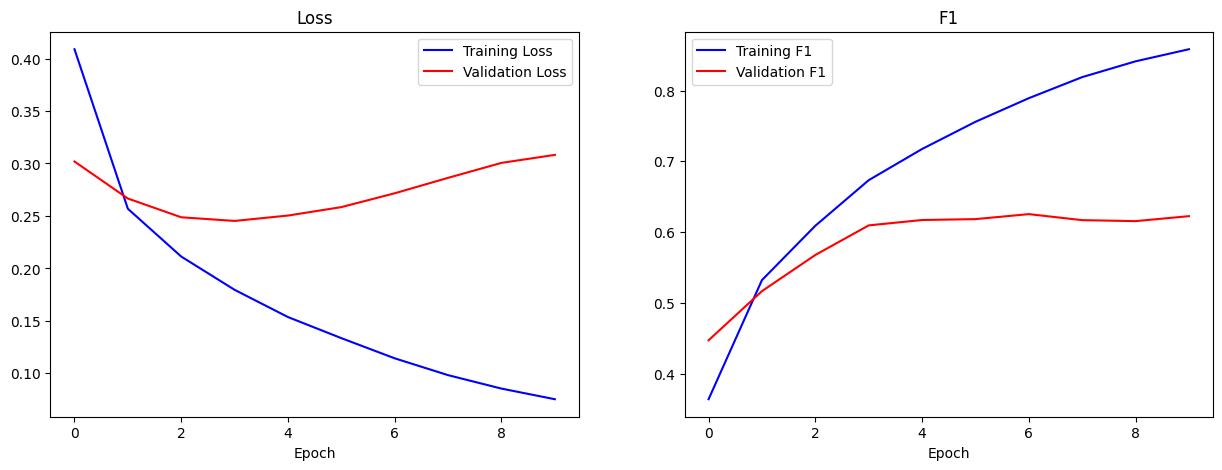

In [37]:
plot(training_loss, validation_loss, training_f1, validation_f1)

In [52]:
# fine_tune(bilstmcrf_word2vec_model, word2vec, val_data, criterion, optimizer, device='cuda', epochs=2)

In [43]:
test_accuracy, test_f1 = test("t1_model4_word2vec.pt", word2vec, test_data, device='cuda', show_labelwise=True, plot=False)
print(("Vaniila RNN with Word2Vec ==> Accuracy: {:.4f}, F1: {:.4f}").format(test_accuracy, test_f1))

Labelwise F1 Scores:
{0: 0.03807746770764223, 1: 0.0947119179163378, 2: 0.07536231884057971, 3: 0.05390185036202735, 4: 0.03986710963455149, 5: 0.05002821139740455, 6: 0.06744868035190615, 7: 0.16692913385826771, 8: 0.1447562776957164, 9: 0.3090783090783091, 10: 0.18656898656898654, 11: 0.1277728482697427, 12: 0.09445424260239074, 13: 0.1881720430107527, 14: 0.08978675645342311, 15: 0.06487569120912613, 16: 0.30303030303030304, 17: 0.12307692307692306, 18: 0.1411764705882353, 19: 0.1823529411764706, 20: 0.0549800796812749, 21: 0.24999999999999997, 22: 0.125, 23: 0.14652014652014653, 24: 0.2222222222222222, 25: 0.12, 26: 0.08035714285714286}
Labelwise Accuracy Scores:
{0: 0.9802257829570284, 1: 0.49586776859504134, 2: 0.6046511627906976, 3: 0.42138364779874216, 4: 0.3870967741935484, 5: 0.48188405797101447, 6: 0.5897435897435898, 7: 0.7162162162162162, 8: 0.7676240208877284, 9: 0.8643410852713178, 10: 0.8741418764302059, 11: 0.8089887640449438, 12: 0.7392638036809815, 13: 0.603448275862

In [38]:
# torch.save(bilstmcrf_word2vec_model, "t1_model4_word2vec.pt")

Labelwise F1 Scores:
{0: 0.03807746770764223, 1: 0.0947119179163378, 2: 0.07536231884057971, 3: 0.05390185036202735, 4: 0.03986710963455149, 5: 0.05002821139740455, 6: 0.06744868035190615, 7: 0.16692913385826771, 8: 0.1447562776957164, 9: 0.3090783090783091, 10: 0.18656898656898654, 11: 0.1277728482697427, 12: 0.09445424260239074, 13: 0.1881720430107527, 14: 0.08978675645342311, 15: 0.06487569120912613, 16: 0.30303030303030304, 17: 0.12307692307692306, 18: 0.1411764705882353, 19: 0.1823529411764706, 20: 0.0549800796812749, 21: 0.24999999999999997, 22: 0.125, 23: 0.14652014652014653, 24: 0.2222222222222222, 25: 0.12, 26: 0.08035714285714286}
Labelwise Accuracy Scores:
{0: 0.9802257829570284, 1: 0.49586776859504134, 2: 0.6046511627906976, 3: 0.42138364779874216, 4: 0.3870967741935484, 5: 0.48188405797101447, 6: 0.5897435897435898, 7: 0.7162162162162162, 8: 0.7676240208877284, 9: 0.8643410852713178, 10: 0.8741418764302059, 11: 0.8089887640449438, 12: 0.7392638036809815, 13: 0.603448275862

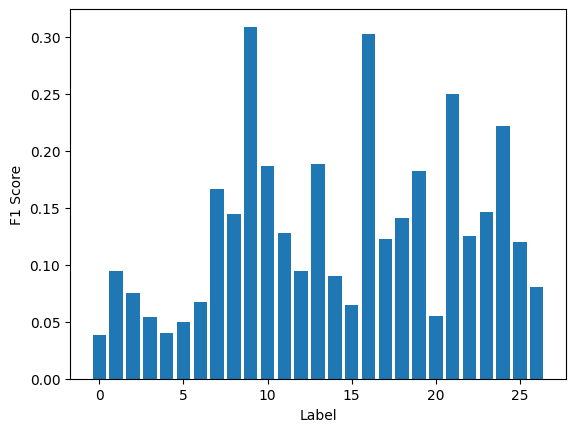

Bi-LSTM CRF with Word2Vec ==> Accuracy: 0.9327, F1: 0.6184


In [60]:
test_accuracy, test_f1 = test("t1_model4_word2vec.pt", word2vec, test_data, device='cuda', show_labelwise=True, plot=True)
print(("Bi-LSTM CRF with Word2Vec ==> Accuracy: {:.4f}, F1: {:.4f}").format(test_accuracy, test_f1))

# For GloVe Embeddings

In [61]:
input_size, hidden_size, output_size = 300, 128, 27
bilstmcrf_glove_model = BiLSTM_CRF(input_size, hidden_size, output_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(bilstmcrf_glove_model.parameters(), lr=0.001)

In [62]:
training_loss, validation_loss, training_f1, validation_f1 = training_and_validation(
            bilstmcrf_glove_model, glove, train_data, val_data, criterion, optimizer, device='cuda', epochs=10)

Epoch 1/10
Training: Loss: 0.5078, Accuracy: 0.8779, F1: 0.2140
Validation: Loss: 0.4058, Accuracy: 0.8983, F1: 0.3025
Epoch 2/10
Training: Loss: 0.3779, Accuracy: 0.9003, F1: 0.3428
Validation: Loss: 0.3739, Accuracy: 0.9029, F1: 0.3553
Epoch 3/10
Training: Loss: 0.3433, Accuracy: 0.9069, F1: 0.3947
Validation: Loss: 0.3649, Accuracy: 0.9032, F1: 0.3752
Epoch 4/10
Training: Loss: 0.3193, Accuracy: 0.9112, F1: 0.4336
Validation: Loss: 0.3628, Accuracy: 0.9034, F1: 0.4034
Epoch 5/10
Training: Loss: 0.2973, Accuracy: 0.9163, F1: 0.4706
Validation: Loss: 0.3675, Accuracy: 0.9025, F1: 0.4062
Epoch 6/10
Training: Loss: 0.2784, Accuracy: 0.9212, F1: 0.5023
Validation: Loss: 0.3690, Accuracy: 0.9024, F1: 0.3994
Epoch 7/10
Training: Loss: 0.2640, Accuracy: 0.9245, F1: 0.5231
Validation: Loss: 0.3772, Accuracy: 0.9029, F1: 0.4306
Epoch 8/10
Training: Loss: 0.2479, Accuracy: 0.9290, F1: 0.5518
Validation: Loss: 0.3842, Accuracy: 0.9020, F1: 0.4296
Epoch 9/10
Training: Loss: 0.2327, Accuracy: 0.9

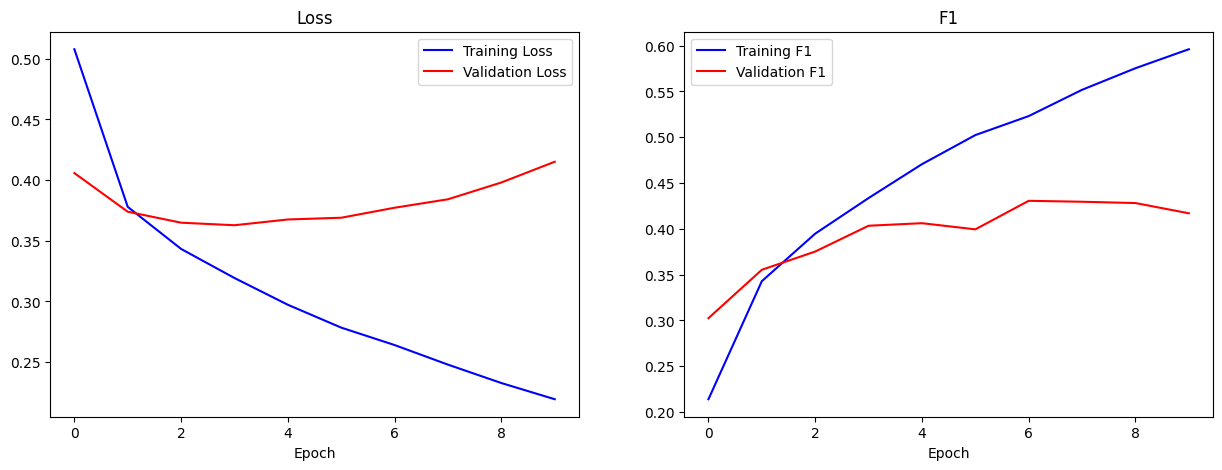

In [63]:
plot(training_loss, validation_loss, training_f1, validation_f1)

In [64]:
torch.save(bilstmcrf_glove_model, "t1_model4_glove.pt")

Labelwise F1 Scores:
{0: 0.036555415509579484, 1: 0.0584795321637427, 2: 0.08904374758033295, 3: 0.0, 4: 0.009425728748472681, 5: 0.015337423312883436, 6: 0.03384615384615385, 7: 0.07130434782608697, 8: 0.10291858678955454, 9: 0.10602678571428571, 10: 0.07602836879432624, 11: 0.046803652968036534, 12: 0.06302521008403361, 13: 0.04848484848484848, 14: 0.09559613319011816, 15: 0.0721747388414055, 16: 0.1455160744500846, 17: 0.0, 18: 0.08571428571428572, 19: 0.07761194029850746, 20: 0.036682615629984046, 21: 0.0, 22: 0.0, 23: 0.1707865168539326, 24: 0.0, 25: 0.0, 26: 0.07586206896551724}
Labelwise Accuracy Scores:
{0: 0.974326292789512, 1: 0.4132231404958678, 2: 0.6686046511627907, 3: 0.0, 4: 0.08709677419354839, 5: 0.18115942028985507, 6: 0.28205128205128205, 7: 0.5540540540540541, 8: 0.6997389033942559, 9: 0.7364341085271318, 10: 0.6132723112128147, 11: 0.2303370786516854, 12: 0.4601226993865031, 13: 0.13793103448275862, 14: 0.5028248587570622, 15: 0.7638190954773869, 16: 0.774774774774

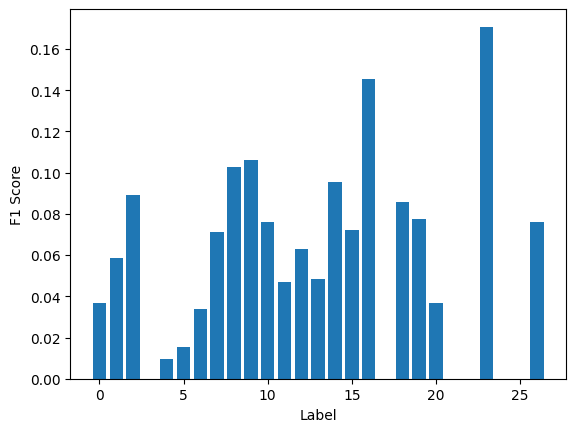

Bi-LSTM CRF with GloVe ==> Accuracy: 0.8993, F1: 0.3839


In [65]:
test_accuracy, test_f1 = test("t1_model4_glove.pt", glove, test_data, device='cuda', show_labelwise=True, plot=True)
print(("Bi-LSTM CRF with GloVe ==> Accuracy: {:.4f}, F1: {:.4f}").format(test_accuracy, test_f1))

# For FastText Embeddings

In [54]:
input_size, hidden_size, output_size = 300, 128, 27
bilstmcrf_fasttext_model = BiLSTM_CRF(input_size, hidden_size, output_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(bilstmcrf_fasttext_model.parameters(), lr=0.001)

In [55]:
training_loss, validation_loss, training_f1, validation_f1 = training_and_validation(
        bilstmcrf_fasttext_model, fasttext, train_data, val_data, criterion, optimizer, device='cuda', epochs=10)

Epoch 1/10
Training: Loss: 0.4115, Accuracy: 0.8998, F1: 0.3543
Validation: Loss: 0.2795, Accuracy: 0.9255, F1: 0.4565
Epoch 2/10
Training: Loss: 0.2442, Accuracy: 0.9329, F1: 0.5130
Validation: Loss: 0.2423, Accuracy: 0.9331, F1: 0.5165
Epoch 3/10
Training: Loss: 0.2044, Accuracy: 0.9422, F1: 0.5870
Validation: Loss: 0.2307, Accuracy: 0.9363, F1: 0.5684
Epoch 4/10
Training: Loss: 0.1766, Accuracy: 0.9486, F1: 0.6479
Validation: Loss: 0.2261, Accuracy: 0.9386, F1: 0.6033
Epoch 5/10
Training: Loss: 0.1539, Accuracy: 0.9542, F1: 0.6921
Validation: Loss: 0.2236, Accuracy: 0.9410, F1: 0.6214
Epoch 6/10
Training: Loss: 0.1344, Accuracy: 0.9593, F1: 0.7290
Validation: Loss: 0.2286, Accuracy: 0.9412, F1: 0.6269
Epoch 7/10
Training: Loss: 0.1181, Accuracy: 0.9639, F1: 0.7592
Validation: Loss: 0.2389, Accuracy: 0.9406, F1: 0.6298
Epoch 8/10
Training: Loss: 0.1048, Accuracy: 0.9677, F1: 0.7862
Validation: Loss: 0.2396, Accuracy: 0.9422, F1: 0.6409
Epoch 9/10
Training: Loss: 0.0922, Accuracy: 0.9

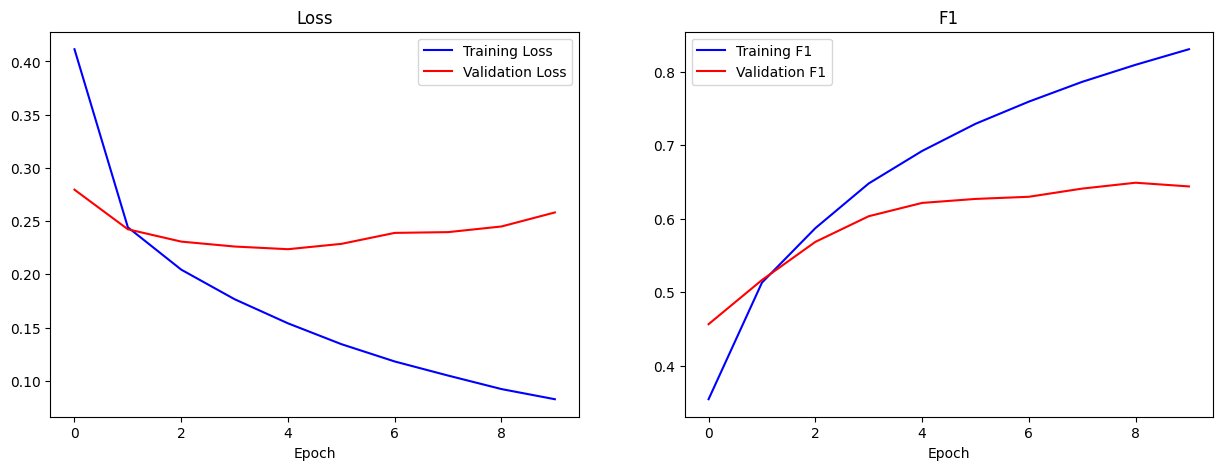

In [56]:
plot(training_loss, validation_loss, training_f1, validation_f1)

In [57]:
torch.save(bilstmcrf_fasttext_model, "t1_model4_fasttext.pt")

Labelwise F1 Scores:
{0: 0.03818503972553268, 1: 0.11285714285714286, 2: 0.09991111111111112, 3: 0.051597051597051594, 4: 0.058123569794050346, 5: 0.05623342175066312, 6: 0.07339449541284404, 7: 0.14112554112554113, 8: 0.08833819241982507, 9: 0.3120274914089347, 10: 0.15460122699386503, 11: 0.1809230769230769, 12: 0.1231613064073797, 13: 0.0907563025210084, 14: 0.10444078947368421, 15: 0.053348651025866556, 16: 0.2325301204819277, 17: 0.1, 18: 0.125, 19: 0.1458823529411765, 20: 0.08080808080808081, 21: 0.0, 22: 0.17857142857142858, 23: 0.15343915343915343, 24: 0.13636363636363635, 25: 0.15, 26: 0.08666666666666667}
Labelwise Accuracy Scores:
{0: 0.9857246904588493, 1: 0.6528925619834711, 2: 0.8168604651162791, 3: 0.39622641509433965, 4: 0.4096774193548387, 5: 0.5760869565217391, 6: 0.676923076923077, 7: 0.7342342342342343, 8: 0.7911227154046997, 9: 0.8798449612403101, 10: 0.8649885583524027, 11: 0.8258426966292135, 12: 0.7576687116564417, 13: 0.46551724137931033, 14: 0.7175141242937854

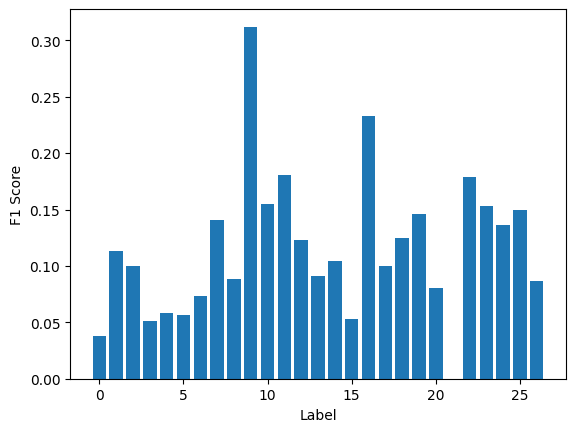

Bi-LSTM CRF with FastText ==> Accuracy: 0.9433, F1: 0.6239


In [59]:
test_accuracy, test_f1 = test("t1_model4_fasttext.pt", fasttext, test_data, device='cuda', show_labelwise=True, plot=True)
print(("Bi-LSTM CRF with FastText ==> Accuracy: {:.4f}, F1: {:.4f}").format(test_accuracy, test_f1))